This is an attempt to predict the casual, registered and total demand for bikeshare for Washington as required by Kaggle. I have analysed the data in a separate file. 

Random Forest is used for prediction and the output is out.csv

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import csv as csv

# import scipy and statsmodels libraries to use inbuild stats functions
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

# read the csv file with bosy temperatures
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [2]:
train_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
test_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [4]:
print(train_df[ ['weather','temp','atemp','humidity','windspeed','casual','registered','count'] ].corr())   

             weather      temp     atemp  humidity  windspeed    casual  \
weather     1.000000 -0.055035 -0.055376  0.406244   0.007261 -0.135918   
temp       -0.055035  1.000000  0.984948 -0.064949  -0.017852  0.467097   
atemp      -0.055376  0.984948  1.000000 -0.043536  -0.057473  0.462067   
humidity    0.406244 -0.064949 -0.043536  1.000000  -0.318607 -0.348187   
windspeed   0.007261 -0.017852 -0.057473 -0.318607   1.000000  0.092276   
casual     -0.135918  0.467097  0.462067 -0.348187   0.092276  1.000000   
registered -0.109340  0.318571  0.314635 -0.265458   0.091052  0.497250   
count      -0.128655  0.394454  0.389784 -0.317371   0.101369  0.690414   

            registered     count  
weather      -0.109340 -0.128655  
temp          0.318571  0.394454  
atemp         0.314635  0.389784  
humidity     -0.265458 -0.317371  
windspeed     0.091052  0.101369  
casual        0.497250  0.690414  
registered    1.000000  0.970948  
count         0.970948  1.000000  


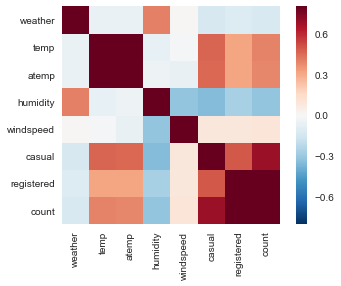

In [5]:
# visual representation of correlations using heatmap
train_features = ['weather','temp','atemp','humidity','windspeed','casual','registered','count']
train_corr = train_df[train_features].corr()
sns.heatmap(train_corr, square = True, vmax = 0.8 )

In [6]:
def normalize(x):
    return (x - x.mean()) / (x.max() - x.min()) + 1 

def cleandata(data):
    # extract useful data from the datetime column
    data.datetime = pd.to_datetime(data.datetime)
    data["hour"] = data.datetime.dt.hour
    data["year"] = data.datetime.dt.year
    # we dont need datetime anymore
    data = data.drop('datetime', 1)

    # normalize numerical data
    data.temp = normalize(data.temp)
    data.atemp = normalize(data.atemp)
    data.windspeed = normalize(data.windspeed)
    data.humidity = normalize(data.humidity)
    data.hour = normalize(data.hour)
    data.year = normalize(data.year)
    return data

print('Data Prep')
dates = test_df['datetime'].values
train_data = cleandata(train_df)
test_data = cleandata(test_df)
print(train_data.columns)
print(test_data.columns)

# extract only columns we are interested in
train_count = train_data['count'].values
train_casual = train_df['casual'].values
train_registered = train_df['registered'].values
train_data = train_data.drop(['casual','registered','count'], axis=1)

train = train_data.values
test = test_data.values

print('Training')
rf = RandomForestRegressor(n_estimators=100)
rf_casual = RandomForestRegressor(n_estimators=100)
rf_registered = RandomForestRegressor(n_estimators=100)

rf = rf.fit(train,train_count)
rf_casual = rf_casual.fit(train,train_casual)
rf_registered = rf_registered.fit(train, train_registered)

print('Predicting')
pred_count = rf.predict(test).astype(int)
pred_casual = rf_casual.predict(test).astype(int)
pred_registered = rf_registered.predict(test).astype(int)
pred_sum = pred_casual + pred_registered
print(pred_count)
print(pred_casual)
print(pred_registered )
print(pred_sum)

#write the output to file along with the datetime
print('Writing to file')
submission = pd.DataFrame({
        "datetime": dates,
        "casual": [max(0, x) for x in pred_casual],
        "registered": [max(0, x) for x in pred_registered],
        "count": [max(0, x) for x in pred_count]
    })
submission.to_csv('out.csv')
print('Done')

Data Prep
Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'hour',
       'year'],
      dtype='object')
Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'hour', 'year'],
      dtype='object')
Training
Predicting
[ 11   4   5 ..., 108 107  57]
[2 1 2 ..., 4 3 3]
[ 10   4   2 ..., 102  98  52]
[ 12   5   4 ..., 106 101  55]
Writing to file
Done


In [7]:
check= pd.read_csv('out.csv')
check.head(25)

,Unnamed: 0,casual,count,datetime,registered
0,0,2,11,2011-01-20 00:00:00,10
1,1,1,4,2011-01-20 01:00:00,4
2,2,2,5,2011-01-20 02:00:00,2
3,3,1,4,2011-01-20 03:00:00,1
4,4,1,3,2011-01-20 04:00:00,1
5,5,0,5,2011-01-20 05:00:00,5
6,6,1,35,2011-01-20 06:00:00,33
7,7,4,105,2011-01-20 07:00:00,100
8,8,13,221,2011-01-20 08:00:00,212
9,9,6,124,2011-01-20 09:00:00,117


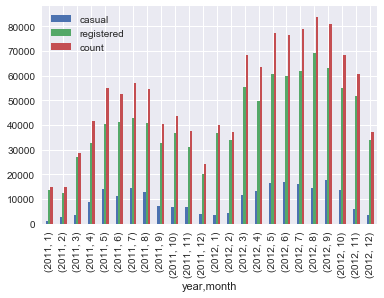

In [10]:
# parse timestamp for output
dt = pd.DatetimeIndex(check['datetime'])
check['date'] = dt.date
check['day'] = dt.day
check['month'] = dt.month
check['year'] = dt.year
check['hour'] = dt.hour
check['dayofweek'] = dt.dayofweek

# plot total users by month and year
check.groupby(['year', 'month'])['casual', 'registered', 'count'].agg(sum).plot(kind = 'bar')

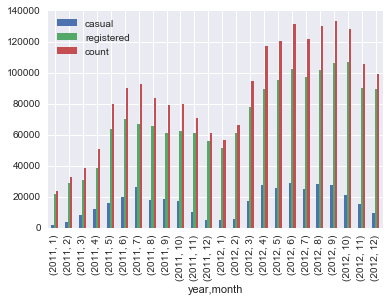

In [11]:
# parse timestamp for training set to verify
dt = pd.DatetimeIndex(train_df['datetime'])
train_df['date'] = dt.date
train_df['day'] = dt.day
train_df['month'] = dt.month
train_df['year'] = dt.year
train_df['hour'] = dt.hour
train_df['dayofweek'] = dt.dayofweek

# plot total users by month and year
train_df.groupby(['year', 'month'])['casual', 'registered', 'count'].agg(sum).plot(kind = 'bar')